In [103]:
from IPython.display import display, Javascript, HTML
import json
display(Javascript("require.config({paths: {d3: 'https://d3js.org/d3.v5.min'}});"))
display(Javascript(filename="knn.js"))


def draw_circles(size=500, levels=4):
    display(Javascript("""
        (function(element){
            require(['knn'], function(knn) {
                knn(element.get(0), %d, %d);
            });
        })(element);
    """ % (size, levels)))

draw_circles(size=700, levels=12)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
import re
import csv
import numpy as np
from collections import Counter, defaultdict

import pandas as pd
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer 

# Parsing

First we'll parse the input file to unify dish names, using wordnet synsets definitins. We'll also try to trim most connection words suc has "with" or "and" that are not every relevant. 

The data will be organized in rows, where each row contains a dish, described by the following features:
  * `year`: Year
  * `week`: Week (where week 1 is the first week of January of the current year)
  * `start_date`: Start date of the corresponding `week` (starts on Mondays) in YYYY-MM-DD format.
  * `end_date`: End date of the corresponding `week` (ends on Fridays) in YYYY-MM-DD format.
  * `day`: Day of the week (from Monday to Friday)
  * `date`: Actual date in YYYY-MM-DD format
  * `category`: One of `Soups`, `Menus` or `Dessert`
  * `subcategory`: Further category, only available for Menus (e.g. one of `vegetarian`, `international`, etc)
  * `price`: Price in euros
  * `allergens`: Allergy information
  * `name`: Name of the dish. After parsing, this is a list of strings, each corresponding to a subpart of the dish (e.g. main versus side-dish)

**Note**: This requires the pands and nltk Python packages, as well as downloading the nltk WordNet corpus, like so:

``` python
import nltk
nltk.download('wordnet')
```

In [30]:
def correct(s):
    """Some replacement rules for unifying dishes names"""
    return s.replace(
        ',', " ").replace(
        '-', ' ').replace(        
        '&', " ").replace(
        "garnish", '').replace(
        "or ", '').replace(
        "of ", '').replace(
        ')', '').replace('(', '')

def parse_name(s):
    """Parse dish names.
    
    The aim is to split them into "components", e.g.
    main vs side-dish, by parsing nominal groups.
    """
    lemmatizer = WordNetLemmatizer()
    parsed = re.split('/|with|"|and', correct(s))
    parsed = [x.strip().lower() for x in parsed if len(x.strip())]
    items = []
    for i, w in enumerate(parsed):
        items.append(' '.join(
            lemmatizer.lemmatize(x) for x in w.split()))
    return items

In [31]:
df = pd.read_csv("./sv_restaurant_data.csv")
# Remove lines with no dishes: 
# This happened because of reduced food options during 2020
df = df.dropna(axis=0, how='any', subset=['name'])
# Parse the remaining ones
df = df.apply(lambda x: [parse_name(y) for y in x] if x.name == 'name' else x)
display(df)

,year,week,start_date,end_date,day,date,category,subcategory,price,allergens,name
0,2019,8,2019-02-25,2019-03-01,Monday,2019-02-25,Soups,NaN,1.10,ACGL,[beef broth]
1,2019,8,2019-02-25,2019-03-01,Monday,2019-02-25,Soups,NaN,1.10,AG,[cream corn soup]
2,2019,8,2019-02-25,2019-03-01,Monday,2019-02-25,Menus,home-style cooking,4.00,AC,"[pasta, ham, small salad]"
3,2019,8,2019-02-25,2019-03-01,Monday,2019-02-25,Menus,vegetarian,5.00,AFG,"[falafel ball, tomato eggplant salad, mint yog..."
4,2019,8,2019-02-25,2019-03-01,Monday,2019-02-25,Menus,fish & seafood,6.00,AD,"[grilled hake, ratatouille, olive potato]"
...,...,...,...,...,...,...,...,...,...,...,...
1931,2020,49,2020-12-07,2020-12-11,Friday,2020-12-11,Soups,NaN,1.15,ACGL,[beef broth]
1932,2020,49,2020-12-07,2020-12-11,Friday,2020-12-11,Soups,NaN,1.15,AG,[mushroom soup]
1933,2020,49,2020-12-07,2020-12-11,Friday,2020-12-11,Menus,vegetarian,4.20,G,"[potato pizza, colorful salad, chive dip]"
1935,2020,49,2020-12-07,2020-12-11,Friday,2020-12-11,Menus,international,6.30,NaN,"[pork fillet, pilaw rice, brussels sprout]"


# Word embeddings

A standard / simple way to encode words as vectors, is to compute a matrix of co-occurences count. Obviously this is a very large ($n \times n$ matrix) and often very sparse matrix. In order to do this, we simply count how many time each word co-occur with another in the same dish. As a result, each word is described by a $n$-dimensional feature vector.

In [32]:
def count_co_occurences(df, norm=False):
    M = defaultdict(lambda: defaultdict(lambda: 0))
    for row in df['name']:
        words = [w[0].upper() + w[1:] for line in row for w in line.split()]
        for i, w1 in enumerate(words):
            for w2 in words[i:]:
                a, b = w1, w2
                if w2 < w1:
                    a, b = b, a
                M[a][b] += 1
    # Now represent it as a symetrical matrix
    words = sorted(M.keys())
    m = np.zeros((len(words), len(words)))
    for i in range(len(words)):
        for j in range(i, len(words)):
            m[i, j] = M[words[i]][words[j]]
            m[j, i] = M[words[i]][words[j]]
    # Normalize optional
    if norm:
        m /= np.diag(m)[None, :]
    # returns
    return words, m
    
dictionary, M = count_co_occurences(df)
print(f'{M.shape[0]} x {M.shape[1]} co-occurence matrix.'
      f' Sparsity factor = {np.count_nonzero(M == 0) / M.shape[0] / M.shape[1]:.3f}')

558 x 558 co-occurence matrix. Sparsity factor = 0.963


In [33]:
def get_knn_graph(dictionary, M, 
                   k=5,
                   dist_threshold=0.,
                   eps=1e-8,
                   max_width=1):
    # Measure distances as cosine similarities
    dists = M / np.sqrt(np.sum(M**2 + eps, axis=1, keepdims=True))
    dists = np.sum(dists[None, :, :] * dists[:, None, :], axis=-1)
    # Build the graph
    with open(f'knn={k}_graph.csv', 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(["Name"] + [x for i in range(k) 
                                      for x in [f"edge_{i + 1}", f"weight_{i + 1}"]])
        for i in range(dists.shape[0]):
            row = [dictionary[i]]
            for j in np.argsort(- dists[i, :])[1:k + 1]:
                if dists[i, j] < dist_threshold:
                    continue
                row.extend((j, dists[i, j]))
            csv_writer.writerow(row)
            
get_knn_graph(dictionary, M, k=2)      

In [ ]:
from IPython.display import display, Javascript, HTML
import json
display(Javascript("require.config({paths: {d3: 'https://d3js.org/d3.v5.min'}});"))
display(Javascript(filename="circles.js"))
display(HTML(filename="circles.css.html"))


def draw_circles(data, width=600, height=400):
    display(Javascript("""
        (function(element){
            require(['circles'], function(circles) {
                circles(element.get(0), %s, %d, %d);
            });
        })(element);
    """ % (json.dumps(data), width, height)))

draw_circles([10, 60, 40, 5, 30, 10], width=500, height=200)

In [330]:
%%javascript
require.config({
    paths: {
        d3: 'https://d3js.org/d3.v5.min'
    }
});

<IPython.core.display.Javascript object>

In [ ]:
https://nbviewer.jupyter.org/github/soxofaan/jupyter-playground/blob/master/jupyter-custom-d3-visualization/jupyter-custom-d3-visualization.ipynb

In [288]:
%%javascript
(function(element) {
    require(['d3'], function(d3) {   
        var data = [1, 2, 4, 8, 16, 8, 4, 2, 1]

        var svg = d3.select(element.get(0)).append('svg')
            .attr('width', 400)
            .attr('height', 200);
        svg.selectAll('circle')
            .data(data)
            .enter()
            .append('circle')
            .attr("cx", function(d, i) {return 40 * (i + 1);})
            .attr("cy", function(d, i) {return 100 + 30 * (i % 3 - 1);})
            .style("fill", "#1570a4")
            .transition().duration(2000)
            .attr("r", function(d) {return 2*d;})
        ;
    })
})(element);

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [278]:
%%time
plot_knn_graph(dictionary, M, k=1)

CPU times: user 626 ms, sys: 621 ms, total: 1.25 s
Wall time: 1.26 s


In [281]:
import plotly.graph_objs as go
import random

f = go.FigureWidget()
f.layout.hovermode = 'closest'
f.layout.hoverdistance = -1 #ensures no "gaps" for selecting sparse data
default_linewidth = 2
highlighted_linewidth_delta = 2

# just some traces with random data points  
num_of_traces = 5
random.seed = 42
for i in range(num_of_traces):
    y = [random.random() + i / 2 for _ in range(100)]
    trace = go.Scatter(y=y, mode='lines', line={ 'width': default_linewidth })
    f.add_trace(trace)

# our custom event handler
def update_trace(trace, points, selector):
    # this list stores the points which were clicked on
    # in all but one trace they are empty
    if len(points.point_inds) == 0:
        return
        
    for i,_ in enumerate(f.data):
        f.data[i]['line']['width'] = default_linewidth + highlighted_linewidth_delta * (i == points.trace_index)


# we need to add the on_click event to each trace separately       
for i in range( len(f.data) ):
    f.data[i].on_click(update_trace)

# let's show the figure 
f.show()

In [83]:
%%time
from matplotlib import pyplot as plt

# The default of 1,000 iterations gives fine results, but I'm training for longer just to eke
# out some marginal improvements. NB: This takes almost an hour!
from sklearn.manifold import TSNE
tsne = TSNE(random_state=1, n_iter=15000, metric="cosine")
embs = tsne.fit_transform(M)

plt.figure(figsize=(16, 16))
# plt.scatter(embs[:, 0], embs[:, 1])
for i in range(len(embs)):
    plt.annotate(dictionary[i], (embs[i, 0], embs[i, 1]))
plt.axis('off')
plt.show()

ValueError: Image size of 93385x84961 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1296x1296 with 1 Axes>

CPU times: user 2min 42s, sys: 1.14 s, total: 2min 43s
Wall time: 1min


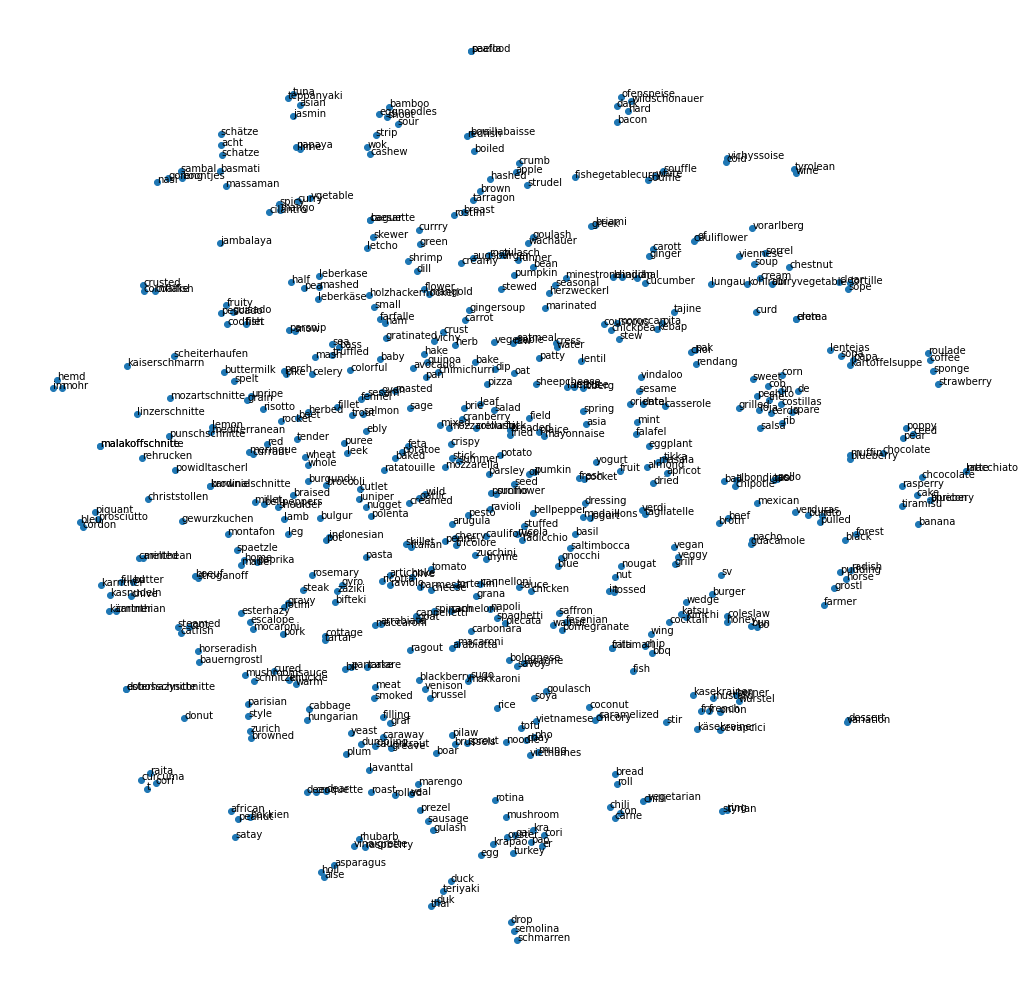

In [88]:
plt.figure(figsize=(18, 18))
plt.scatter(embs[:, 0], embs[:, 1])
for i in range(len(embs)):
    plt.annotate(dictionary[i], (embs[i, 0], embs[i, 1]))
plt.axis('off')
plt.show()

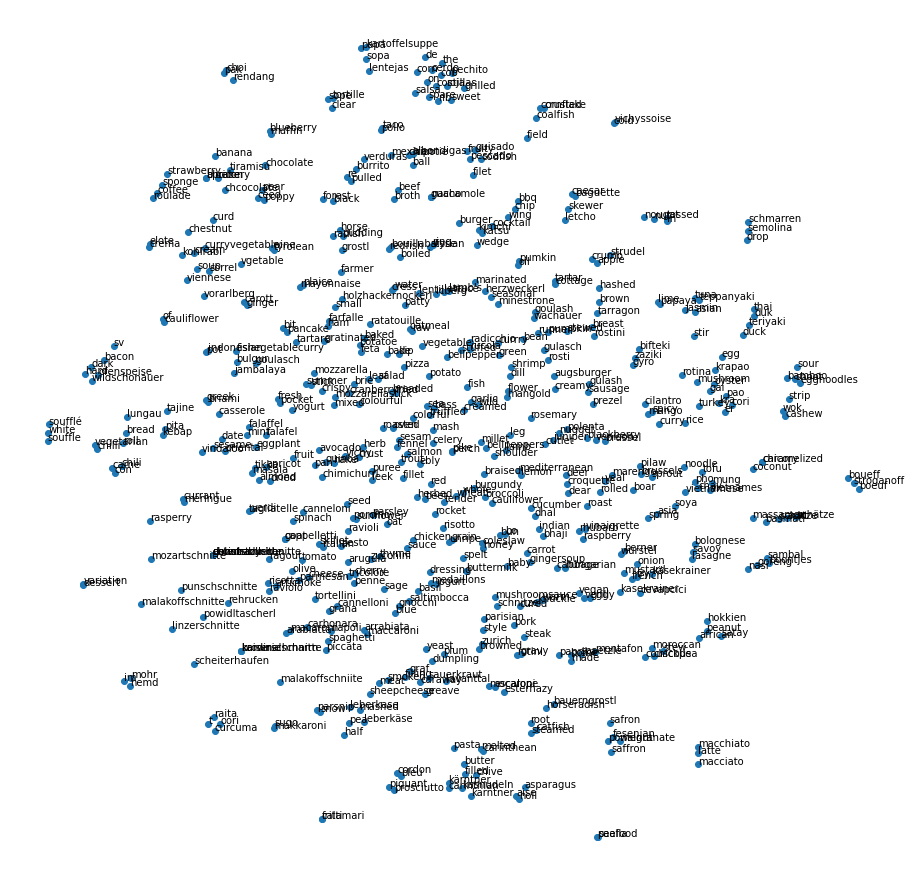

In [78]:
%%time

In [48]:
import networkx

def plot_knn_graph(dictionary, M, k=5):
    pass

# Visualizations

### The many names of Schnitzel

We all know Wednesday is Schnitzel day, 

In [34]:
def get_schnitzel_names(df):
    schnitzel_names = df[(df["day"] == "Wednesday") & (df["subcategory"] == "home-style cooking")]
    return schnitzel_names.name.map(lambda x: x[0]).value_counts()
    
get_schnitzel_names(df)

breaded fried turkey schnitzel        9
breaded fried pork schnitzel          9
breaded fried cured pork schnitzel    8
breaded fried chicken schnitzel       7
breaded fried chicken                 6
turkey cordon bleu                    4
pork cordon bleu                      4
chicken cordon bleu                   3
turkey schnitzel                      3
cordon bleu                           2
pork schnitzel parisian style         1
piquant cordon bleu filled            1
chicken piccata                       1
breaded fried turkey cordon bleu      1
pork schnitzel                        1
piquant cordon bleu                   1
chicken fillet                        1
turkey schnitzel parisian style       1
cured pork schnitzel                  1
Name: name, dtype: int64

### Price Inequalities ?

In [ ]:


def get_average_prices(df):
    mains = df[df["category"] == "Menus"]
    for v in mains.subcategory.unique():
        prices = df[df["subcategory"] == v].price
        avg = prices.mean()
        print(v, avg)

###  Days of the week

In [ ]:

                
def get_frequencies(df, day=None):
    mains = df[df["category"] == "Menus"]
    if day is None:
        return df.subcategory.value_counts()
    else:
        return df[df["day"] == day].subcategory.value_counts()
        
def workcloud(df, day=None):
    words = list(df.name)
    words = [y for l in words for x in l for y in x.replace("of", '').replace("sauce", '').split()]
    counts = Counter(words)
    if day is None:
        return counts
    else:
        words = list(df[df["day"] == day].name)
        #words = [x for l in words for x in l]
        words = [y for l in words for x in l for y in x.replace("of", '').replace("sauce", '').split()]
        ncounts = Counter(words)
        total = sum(counts.values(), 0.0)
        for key in counts:
            counts[key] /= total
        total = sum(ncounts.values(), 0.0)
        for key in ncounts:
            ncounts[key] /= total
        ncounts.subtract(counts)
        return ncounts

In [ ]:
Mapping ingredients to allergies
csp

In [25]:
with open("./sv_restaurant_data.csv", 'r') as f:
    r = csv.DictReader(f)
    for line in r:
        print(parse_name(line["name"]))

['beef broth']
['cream of corn soup']
['pasta', 'ham', 'small salad']
['falafel balls', 'tomato eggplant salad', 'mint yogurt']
['grilled hake', 'ratatouille', 'olive potatoes']
['poppy seed cheese cake']
['beef broth']
['creamed garlic soup']
['pumpkin spinach pan', 'dates', 'nuts', 'bulgur']
['käsekrainer', 'french fries', 'onion mustard']
['gratinated chicken filet', 'tomato', 'mozzarella', 'bell peper', 'zucchini', 'herb pasta']
['latte macchiato cake']
['beef broth']
['minestrone']
['potato vegetable strudel', 'leaf salad', 'herb dip']
['breaded fried chicken schnitzel', 'rice']
['wok noodles', 'turkey strips', 'vegetables', 'cashews']
['yogurt fruit cake']
['beef broth']
['cream of cauliflower soup']
['grilled leberkäse', 'green beans', 'dill', 'potatoes']
['jambalaya', 'bulgur']
['esterházy beef escalope', 'green pasta', 'root vegetables']
['apricot cake']
['beef broth']
['creamed basil soup']
['buttermilk', 'vegetable curry', 'spelt']
['breaded fried plaice', 'parsley potatoes'

In [7]:
f

,year,week,start_date,end_date,day,date,category,subcategory,price,allergens,name
0,2019,8,2019-02-25,2019-03-01,Monday,2019-02-25,Soups,NaN,1.10,ACGL,beef broth/garnish
1,2019,8,2019-02-25,2019-03-01,Monday,2019-02-25,Soups,NaN,1.10,AG,cream of corn soup
2,2019,8,2019-02-25,2019-03-01,Monday,2019-02-25,Menus,home-style cooking,4.00,AC,pasta with ham/small salad
3,2019,8,2019-02-25,2019-03-01,Monday,2019-02-25,Menus,vegetarian,5.00,AFG,falafel balls/tomato eggplant salad/mint yogurt
4,2019,8,2019-02-25,2019-03-01,Monday,2019-02-25,Menus,fish & seafood,6.00,AD,grilled hake/ratatouille/olive potatoes
5,2019,8,2019-02-25,2019-03-01,Monday,2019-02-25,Dessert,NaN,1.30,ACG,poppy seed cheese cake
6,2019,8,2019-02-25,2019-03-01,Tuesday,2019-02-26,Soups,NaN,1.10,ACGL,beef broth/garnish
7,2019,8,2019-02-25,2019-03-01,Tuesday,2019-02-26,Soups,NaN,1.10,AG,creamed garlic soup
8,2019,8,2019-02-25,2019-03-01,Tuesday,2019-02-26,Menus,vegetarian,4.00,AH,"pumpkin spinach pan/dates, nuts/bulgur"
9,2019,8,2019-02-25,2019-03-01,Tuesday,2019-02-26,Menus,home-style cooking,5.00,GM,"""Käsekrainer""/french fries/onion mustard"
